## Notebook 2.2. Understanding and Preprocessing of Moodle Logs

For all intents and purposes, this should be considered as the first real notebook that is part of the thesis work. In it, we will take the original student log file and perform the necessary manipulations to ensure that we have a dataset with the potential to be useful.

We will use this notebook to filter the Moodle logs to only include the courses of our interest and estimate course duration.

#### 1. A Small overview of the logs and each column

The presented logs report to interactions with the Moodle LMS:

    - Each interaction with the LMS is recorded sequentially:
        When is the action performed,
        What is the nature of the interaction,
        Where is the actor when the action is performed,
        Who performed the interaction,
        In the context of which course page,
        What is the specific link,
                
    - Each user is uniquely identified by the userID,
    - Each course is uniquely identified by the courseID,
    - Each specific interaction is recorded -> action performed and clicked url, 
    - Each click is timestamped,
    - The actor's IP is recorded,

A brief description of each column follows:

##### component
An identifier of the component,

##### TStamp	
A timestamp of the event,

##### userid
Unique numerical identifier of user -> be it student, faculty or other,

##### ip
ip adress used by the user when interactiong with the LMS system,

##### course
Unique numerical identifier of a course,

##### objecttable
meaning unclear at the moment - to check with other Moodle Sources,

##### action
categorization of nature of the interaction

#### target	
category of the page the student is accessing,

##### cd_discip
The identifier of the course in the other institutional software


#### 2. We'll start this notebook by importing all relevant packages and data

All data is stored in the csv files that were exported in the previous notebook. 

In order to minimize unecessary steps, as we import these csv files we will immediatly remove, from each dataset:
1. The first unnamed column,
2. All columns that are entirely made of missing values - we have detected some.
3. All numerical columns that are immediatly recognied as categorical (or likely to be categorical values) are also immediatly declared as categoricals - this does not mean that, upon further assessment, other features may be converted to objects,
4. All features that display no null values and have a single value are promptly removed as well, 
5. No preprocessing of time related features is performed at this stage - namely because the features realted with time may require further assessment.

In [35]:
#import libs
import pandas as pd
import numpy as np
from pandas.tseries.offsets import *
import re
from copy import copy, deepcopy

#viz related tools
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import LogNorm, Normalize
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator
import matplotlib as mpl
from matplotlib import cm

import seaborn as sns
from tqdm.notebook import tqdm, trange
tqdm.pandas(desc="Progress")

sns.set()
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [5]:
#additionally, we will also define preemptively some golbal variables that may come in handy

#colors for vizualizations
nova_ims_colors = ['#BFD72F', '#5C666C']

#standard color for student aggregates
student_color = '#474838'

#standard color for course aggragates
course_color = '#1B3D2F'

#standard continuous colormap
standard_cmap = 'viridis_r'

In [6]:
#loading student log data 
student_logs = pd.concat(pd.read_excel('../Data/Nova_IMS_logs_Moodle.xlsx', sheet_name = None,
                           dtype = {
                                   'userid': float,
                                   'courseid': object,
                                   'TStamp' : pd.datetime,
                           })).drop(['eventname', 'CourseShortname', 'startdate', 'enddate'], axis = 1).dropna(how = 'all', axis = 1) #logs

#other tables with support information
support_table = pd.read_csv('../Data/Nova_IMS_support_table.csv',
                             dtype = {
                                 'cd_curso' : object,
                                 'courseid' : float,
                                 'userid' : float,
                                 'assign_id': object,
                             }, parse_dates = ['startdate', 'end_date']).drop('Unnamed: 0', axis = 1)

#after checking, we note that time and stime report to the same date and differ in 1 hour, hence, we will only keep the time column
#additionally, we will make the immediate conversion of time
student_logs = student_logs.rename(columns = {
                    'TStamp': 'time', #readjusting names to match other information I already have
                    'courseid': 'course', #moodle courseid
                    'cd_discip' : 'courseid', #netpa course id
                    }).reset_index(drop = True).sort_values(by = 'time')

student_logs['userid'], support_table['courseid'], support_table['userid'] = student_logs['userid'].astype(object), support_table['courseid'].astype(object), support_table['userid'].astype(object)

### We start by taking a preliminary look at the logs

In [7]:
student_logs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4829394 entries, 117552 to 4773753
Data columns (total 9 columns):
 #   Column          Dtype         
---  ------          -----         
 0   component       object        
 1   action          object        
 2   target          object        
 3   objecttable     object        
 4   userid          object        
 5   course          object        
 6   time            datetime64[ns]
 7   CourseFullname  object        
 8   courseid        object        
dtypes: datetime64[ns](1), object(8)
memory usage: 368.5+ MB


In [8]:
student_logs.describe(include ='all', datetime_is_numeric = True).T

,count,unique,top,freq,mean,min,25%,50%,75%,max
component,4829394,38,core,1928779,NaT,NaT,NaT,NaT,NaT,NaT
action,4829394,43,viewed,4439966,NaT,NaT,NaT,NaT,NaT,NaT
target,4829394,90,course,1749544,NaT,NaT,NaT,NaT,NaT,NaT
objecttable,2921683,64,quiz_attempts,962760,NaT,NaT,NaT,NaT,NaT,NaT
userid,4829394.0,2631.0,24.0,33174.0,NaT,NaT,NaT,NaT,NaT,NaT
course,4829394.0,340.0,1219.0,105791.0,NaT,NaT,NaT,NaT,NaT,NaT
time,4829394,NaN,NaN,NaN,2021-01-31 04:35:53.171790592,2020-08-26 11:51:00,2020-11-12 22:32:00,2021-01-22 20:56:00,2021-04-19 18:18:00,2021-07-30 22:02:00
CourseFullname,4829394,341,202021 - Marketing Digital e ComÃ©rcio EletrÃ³...,105791,NaT,NaT,NaT,NaT,NaT,NaT
courseid,4816821.0,272.0,200165.0,129264.0,NaT,NaT,NaT,NaT,NaT,NaT


In [9]:
student_logs.head()

,component,action,target,objecttable,userid,course,time,CourseFullname,courseid
117552,mod_forum,viewed,course_module,forum,4867.0,1214,2020-08-26 11:51:00,202021 - InteligÃªncia EconÃ³mica e Competitiv...,400033
201301,mod_forum,viewed,course_module,forum,4867.0,1242,2020-08-26 11:51:00,202021 - Metodologias e TÃ©cnicas de AnÃ¡lise ...,400037
201300,core,viewed,course,NaN,4867.0,1242,2020-08-26 11:51:00,202021 - Metodologias e TÃ©cnicas de AnÃ¡lise ...,400037
117551,core,viewed,course,NaN,4867.0,1214,2020-08-26 11:51:00,202021 - InteligÃªncia EconÃ³mica e Competitiv...,400033
282504,core,viewed,course,NaN,4867.0,1284,2020-08-26 11:51:00,202021 - TÃ©cnicas AnalÃ­ticas Estruturadas pa...,400032


I am unable to convert courseid to an object, which hints at some of these courses as different. We've identified 2 instances:

1. 100012-100013
2. 200032-400007

In the support table, all of the 4 courses are represented. We can get the students attending each individual course and make the proper assignment.

In [10]:
#use this cell to write any additional piece of code that may be required

### And follow-up by looking at the support table

In [11]:
support_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40450 entries, 0 to 40449
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   cd_curso         40450 non-null  object        
 1   semestre         40450 non-null  object        
 2   courseid         40450 non-null  object        
 3   statusAvaliacao  37611 non-null  object        
 4   userid           40450 non-null  object        
 5   assignment_mark  37611 non-null  float64       
 6   assign_id        37611 non-null  object        
 7   nm_curso_pt      40450 non-null  object        
 8   ds_discip_pt     40450 non-null  object        
 9   end_date         40450 non-null  datetime64[ns]
 10  startdate        40450 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(1), object(8)
memory usage: 3.4+ MB


In [12]:
support_table.describe(include ='all', datetime_is_numeric = True).T

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
cd_curso,40450,28,9434,8175,NaN,NaN,NaN,NaN,NaN,NaN,NaN
semestre,40450,6,S1,16882,NaN,NaN,NaN,NaN,NaN,NaN,NaN
courseid,40450.0,251.0,200071.0,1465.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
statusAvaliacao,37611,13,Nota Parcial 1,11489,NaN,NaN,NaN,NaN,NaN,NaN,NaN
userid,40450.0,2305.0,3248.0,56.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
assignment_mark,37611.0,NaN,NaN,NaN,14.511157,0.0,12.7,15.88,17.7,20.0,4.548028
assign_id,37611,1781,1553,179,NaN,NaN,NaN,NaN,NaN,NaN,NaN
nm_curso_pt,40450,28,Mestrado em Gestão de Informação,8175,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ds_discip_pt,40450,239,Gestão do Conhecimento,1465,NaN,NaN,NaN,NaN,NaN,NaN,NaN
end_date,40450,NaN,NaN,NaN,2021-03-30 14:51:03.337453568,2020-11-06 00:00:00,2021-01-22 00:00:00,2021-01-22 00:00:00,2021-06-25 00:00:00,2021-06-25 00:00:00,NaN


In [13]:
support_table.head()

,cd_curso,semestre,courseid,statusAvaliacao,userid,assignment_mark,assign_id,nm_curso_pt,ds_discip_pt,end_date,startdate
0,8259,S1,100001.0,NaN,1544.0,NaN,NaN,Licenciatura em Sistemas e Tecnologias de Info...,Álgebra Linear,2021-01-22,2020-09-07
1,8259,S1,100001.0,Nota Parcial 1,1556.0,13.9,0,Licenciatura em Sistemas e Tecnologias de Info...,Álgebra Linear,2021-01-22,2020-09-07
2,8259,S1,100001.0,Nota Parcial 2,1556.0,8.7,1,Licenciatura em Sistemas e Tecnologias de Info...,Álgebra Linear,2021-01-22,2020-09-07
3,9155,S1,100001.0,Nota Parcial 1,1564.0,16.8,2,Licenciatura em Gestão de Informação,Álgebra Linear,2021-01-22,2020-09-07
4,9155,S1,100001.0,Nota Parcial 2,1564.0,7.3,3,Licenciatura em Gestão de Informação,Álgebra Linear,2021-01-22,2020-09-07


Correcting instances where the logs recorded 

In [14]:
#getting list of courses
students_course_1 = support_table[support_table['courseid'] == 100012.0]['userid'].unique()
students_course_2 = support_table[support_table['courseid'] == 100013.0]['userid'].unique()
students_course_3 = support_table[support_table['courseid'] == 200032.0]['userid'].unique()
students_course_4 = support_table[support_table['courseid'] == 400007.0]['userid'].unique()

In [15]:
#converting 
student_logs['courseid'] = np.where(student_logs['courseid'] == '100012-100013',
                                np.where(student_logs['userid'].isin(students_course_1),
                                   100012.0, #course 1
                                   100013.0), #course 2,    
                                np.where(student_logs['courseid'] == '200032-400007',
                                  np.where(student_logs['userid'].isin(students_course_3),
                                   200032.0, #course 3
                                   400007.0), #course 4,
                                student_logs['courseid'] #remain the same in all others      
                                           ))

#converting to float to get the .0 and back to object again
student_logs['courseid'] = student_logs['courseid'].astype(float)
student_logs['courseid'] = student_logs['courseid'].astype(object)

del students_course_1, students_course_2, students_course_3, students_course_4

In [16]:
#use this cell to write any additional piece of code that may be required

### Goal 1: 

One of the first thing to do is to consider the set of students and courses we intend to use. We have, from our support table, a list of the courses and students that we are interested in.

Unlike in the situation of R. Gonz, we have to account for semesters, as there are instances of the same course - better said different courses with the same internal reference in Netpa have different course reference codes on Moodle.

We need to start by making sure that we have a real way to properly sinchronize both databases - as to avoid joining together students attending different versions of a course.

A first, preliminary approach is to only retains logs from courses for which we have records. We  will not perform an inner pairs on the logs and see how they match up to programid-semester-courseid. We would expect there to be a reasonable match between both.

In [17]:
#We start by filtering by all courses that are in our support table
course_array = support_table['courseid'].unique()

#We start by filtering by all courses that are in our support table
students = support_table['userid'].unique()

#then, we keep logs of the courses of interest   
student_logs = student_logs[student_logs['courseid'].isin(course_array)].sort_values(by = 'time')

#and the students
student_logs = student_logs[student_logs['userid'].isin(students)].reset_index(drop = True)

#and get the complete list of students interacting with the system - graded or not
student_courses = student_logs.filter(['courseid', 'course', 'userid']).drop_duplicates().reset_index(drop = True)

#take a look at slices dataset
student_logs.describe(include ='all', datetime_is_numeric = True).T

,count,unique,top,freq,mean,min,25%,50%,75%,max
component,4400020,27,core,1696151,NaT,NaT,NaT,NaT,NaT,NaT
action,4400020,26,viewed,4151426,NaT,NaT,NaT,NaT,NaT,NaT
target,4400020,60,course,1625929,NaT,NaT,NaT,NaT,NaT,NaT
objecttable,2659376,43,quiz_attempts,928527,NaT,NaT,NaT,NaT,NaT,NaT
userid,4400020.0,2241.0,6826.0,11601.0,NaT,NaT,NaT,NaT,NaT,NaT
course,4400020.0,288.0,1219.0,101481.0,NaT,NaT,NaT,NaT,NaT,NaT
time,4400020,NaN,NaN,NaN,2021-01-31 02:42:29.972207360,2020-08-26 11:51:00,2020-11-12 18:46:00,2021-01-22 16:21:00,2021-04-19 19:02:00,2021-07-30 22:02:00
CourseFullname,4400020,290,202021 - Marketing Digital e ComÃ©rcio EletrÃ³...,101481,NaT,NaT,NaT,NaT,NaT,NaT
courseid,4400020.0,231.0,200165.0,121009.0,NaT,NaT,NaT,NaT,NaT,NaT


From this filtering process, we get **4 400 020 recorded interactions**, performed by **2 140** unique students in the context of **231 curricular units**.

We can remove courses such as Research methodologies, Thesis and the doctoral discipline experimental design. It seems that there are instances of distinct classes of the same curricular unit - just different classes.

We will treat different courses differently. The following courses will be removed outright:
1. Research Methodologies - 200163.0,
2. Experimental Design - 200086.0, 
3. Thesis - 200131.0
4. Dissertação - 200040.0
5. Thesis follow-up - 200050.0
6. Thesis Seminars - 200263.0
7. Methodology of Legal Research - 200250.0
8. Research Seminar - 300005.0

In [18]:
#with pd.option_context('display.max_rows', None,):
#    print(student_logs[['courseid', 'course', 'CourseFullname']].value_counts())

In [19]:
#getting a list of courses to eliminate
courseid_to_eliminate = [200086.0, 
                         200163.0,
                         200131.0,
                         200040.0,
                         200150.0, 
                         200263.0,
                         200250.0,
                         300005.0,
                        ]

#adapt student_logs and support_table to match courses to eliminate
student_logs = student_logs[~student_logs['courseid'].isin(courseid_to_eliminate)]
support_table = support_table[~support_table['courseid'].isin(courseid_to_eliminate)]
student_courses = student_courses[~student_courses['courseid'].isin(courseid_to_eliminate)]

At this point, we have to deal, to the best of our ability with mismatches between courseid and course - instances where a specific courseid refers to more than one course.

These will be relevant if and when we have students a student attending multiple courses within a courseid. Because in these instances we will need an additional identifier in order to promote a verifiable association between course a(the finer grained resolution) and courseid - the Netpa reference we have.

We can start by counting the number of courses, each courseid student pair is registered to - we have no other option than to verifyu each course id individually and deal with it in the most approppriate manner. 

In [20]:
#we create a pivot_table
student_courses_piv = pd.pivot_table(student_courses, index = ['courseid', 'userid'], values = 'course',
                                aggfunc = 'count')

#and only keep courseid-student pairs for whom there is more than 1 occurrence of course
student_courses_piv = student_courses_piv[student_courses_piv['course'] > 1]

In [21]:
#with pd.option_context('display.max_rows', None,): #uncomment to see 
#    display(student_courses_piv)

**The following Courseids have the same student attending in different semesters:**
1. **Course 100008.0**,
2. **Course 100010.0**
3. **Course 200070.0**
4. **Course 200014.0**

Each version is easily mergeable with netpa data via a semester-courseid pairing,

**The following Courseids have the same student displaying activity in versions of the same NetPa course whithin a semester:**

1. **Course 200197.0** - 1 student in these conditions,
2. **Course 200195.0** - Multiple students
3. **Course 200193.0** - 1 student, 
4. **Course 200166.0** - a couple of students
5. **Course 200165.0** - 1 student, 
6. **Course 200146.0** - different classes, same student,
7. **Course 200049.0** - 1 student
8. **Course 200013.0** - 5 students, 
9. **Course 200012.0** - 1 student

In this instance, we can treat the unique courseid pairing as sufficient for identification of the course. It seems that the different courses result from registration in different classes of the same version of the course.

**The following courses need to be verified more thoroughly:**
1. **Course 200194.0** -> different versions occur (T3 and T4), with different classes being registered in T4
2. **Course 200170.0** -> no id on the semester - will need to cross with support table
3. **Course 200167.0** -> no id on semester, will need to check further -> problably different programs are in the mix -> 1488 is S2

### Section for additional verification using Support Table

This small section will assist us in the decision on how to deal with 3 courses.
Courses to verify:

1. **Course 200194.0** -> different versions occur (T3 and T4), with different classes being registered in T4
2. **Course 200170.0** -> no id on the semester - will need to cross with support table
3. **Course 200167.0** -> no id on semester, will need to check further -> problably different programs are in the mix -> 1488 is S2

In [22]:
#courses
to_verify = [
            200194.0,
            200170.0, 
            200167.0
            ]

#filtering support table 
verification = support_table[support_table['courseid'].isin(to_verify)]
verification[['cd_curso', 'nm_curso_pt', 'courseid', 'semestre', 'ds_discip_pt']].drop_duplicates(
    subset = ['cd_curso', 'courseid', 'semestre']).sort_values(by = 'nm_curso_pt')

,cd_curso,nm_curso_pt,courseid,semestre,ds_discip_pt
27713,9435,Mestrado em Data-Driven Marketing,200170.0,S2,Consumer Behavior Insights
39304,9435,Mestrado em Data-Driven Marketing,200194.0,T4,Transformação Digital
38904,4281,Mestrado em Estatística e Gestão de Informação,200194.0,T4,Transformação Digital
27695,4281,Mestrado em Estatística e Gestão de Informação,200170.0,S2,Consumer Behavior Insights
27111,4281,Mestrado em Estatística e Gestão de Informação,200167.0,S2,Big Data Analytics
26934,9434,Mestrado em Gestão de Informação,200167.0,S2,Big Data Analytics
27677,9434,Mestrado em Gestão de Informação,200170.0,S2,Consumer Behavior Insights
38907,9434,Mestrado em Gestão de Informação,200194.0,T4,Transformação Digital
26938,7512,Mestrado em Métodos Analíticos Avançados,200167.0,S2,Big Data Analytics
38101,7512,Mestrado em Métodos Analíticos Avançados,200194.0,T3,Transformação Digital


We see, from the data in the support table, that there are multiple instances of different programs having similar curricular units - that have, each, a different version of the same curricular unit.

Therefore, we will be required to perform the merger at the level of resolution we can: That is using Course ID, Semester and UserID.

Additionally, we see that most of the of the courses have the semester indication in their name. We can use this knowledge to extract the number semester and store it in a columns.

Then, we will need to take care of duplicates that may surface:

In [23]:
#we get all nonduplicate rows 
synch_df = student_logs.filter(['courseid', 'userid', 'course', 'CourseFullname']).drop_duplicates(subset = ['course', 'courseid', 'userid'],
                                                                                        keep = 'first') #will allow us to understand when the first student interaction occurs

#extracts an S or T followed by a digit - not perferct, but workable
synch_df['semester'] = synch_df['CourseFullname'].str.extract(pat = '([ST]\d)') #matches for capitol S or T followed by digit
synch_df.describe(include = 'all', datetime_is_numeric = True)

,courseid,userid,course,CourseFullname,semester
count,16329.0,16329.0,16329,16329,14486
unique,223.0,2025.0,249,249,6
top,200167.0,4608.0,1177,MSI 2020/21 - Marketing Strategy Innovation,S1
freq,334.0,23.0,301,301,5867


In [24]:
#now, we get to perform an inner merge - we not expecting an increase in rows
synch_df = pd.merge(synch_df, support_table.filter(['cd_curso','semestre', 'courseid', 'nm_curso_pt', 'ds_discip_pt', 'userid']).drop_duplicates(), on = ['courseid', 'userid'])

#previous step will definitely generate immediate duplicates -> multiple courses for same course id
synch_df

,courseid,userid,course,CourseFullname,semester,cd_curso,semestre,nm_curso_pt,ds_discip_pt
0,400033.0,4867.0,1214,202021 - InteligÃªncia EconÃ³mica e Competitiv...,S1,4964,S1,Pós-Graduação em Gestão de Informações e Segur...,Inteligência Económica e Competitiva
1,400037.0,4867.0,1242,202021 - Metodologias e TÃ©cnicas de AnÃ¡lise ...,S1,4964,S1,Pós-Graduação em Gestão de Informações e Segur...,Metodologias e Técnicas de Análise e de Prospe...
2,400032.0,4867.0,1284,202021 - TÃ©cnicas AnalÃ­ticas Estruturadas pa...,S1,4964,S1,Pós-Graduação em Gestão de Informações e Segur...,Técnicas Analíticas Estruturadas para Análise ...
3,400035.0,4867.0,1266,202021 - DinÃ¢micas Regionais de SeguranÃ§a e ...,S1,4964,S1,Pós-Graduação em Gestão de Informações e Segur...,Dinâmicas Regionais de Segurança e Defesa
4,200165.0,5916.0,1506,202021 - MÃ©todos Descritivos de Data Mining -...,S1,9434,S1,Mestrado em Gestão de Informação,Métodos Descritivos de Data Mining
...,...,...,...,...,...,...,...,...,...
14666,100014.0,3288.0,1355,202021 - Base de Dados II - S2,S2,9155,S2,Licenciatura em Gestão de Informação,Base de Dados II
14667,400106.0,6588.0,1401,Big Data for Finance,NaN,4974,S2,Pós-Graduação em Data Science for Finance,Big Data for Finance
14668,400106.0,6512.0,1401,Big Data for Finance,NaN,4974,S2,Pós-Graduação em Data Science for Finance,Big Data for Finance
14669,200167.0,4118.0,1512,Big Data Analytics (night),NaN,9434,S2,Mestrado em Gestão de Informação,Big Data Analytics


Now that we have correctly managed to perform the merger, we must take into account the fact that we were not able to merge semester-wise.

We will find semestral mismatches (i.e. Semester and Semestre have different values) of 2 kinds:

1. Courses whose Moodle name has no indication of semester -> making the column derived from moodle a Nan,
    
2. Courses who have the same students attending in the first semester and second semester version of the course,
    - This occurs on courseids 100008.0, 100010.0 and 200070.0 (course 200014.0 did not come through the filtering process)

In [25]:
#this cell allows us to verify which courses (according to Moodle) are registered to a semester differently to NetPA
semester_mismatch =  synch_df[synch_df['semester'] != synch_df['semestre']]['course'].unique()
synch_df[synch_df['course'].isin(semester_mismatch)].drop_duplicates(['course', 'semester', 'semestre']).sort_values('courseid')

,courseid,userid,course,CourseFullname,semester,cd_curso,semestre,nm_curso_pt,ds_discip_pt
1622,100007.0,4718.0,1185,202021 - AnÃ¡lise EconÃ³mica - S2,S2,9155,S1,Licenciatura em Gestão de Informação,Análise Económica
3282,100008.0,4716.0,1353,202021 - AnÃ¡lise MatemÃ¡tica I - S2,S2,8259,S2,Licenciatura em Sistemas e Tecnologias de Info...,Análise Matemática I
3280,100008.0,4716.0,1187,202021 - AnÃ¡lise MatemÃ¡tica I - S1,S1,8259,S2,Licenciatura em Sistemas e Tecnologias de Info...,Análise Matemática I
2033,100008.0,4717.0,1353,202021 - AnÃ¡lise MatemÃ¡tica I - S2,S2,9155,S1,Licenciatura em Gestão de Informação,Análise Matemática I
520,100008.0,4629.0,1187,202021 - AnÃ¡lise MatemÃ¡tica I - S1,S1,8259,S1,Licenciatura em Sistemas e Tecnologias de Info...,Análise Matemática I
519,100010.0,4629.0,1354,202021 - AnÃ¡lise MatemÃ¡tica II - S2,S2,8259,S2,Licenciatura em Sistemas e Tecnologias de Info...,Análise Matemática II
517,100010.0,4629.0,1188,202021 - AnÃ¡lise MatemÃ¡tica II - S1,S1,8259,S2,Licenciatura em Sistemas e Tecnologias de Info...,Análise Matemática II
518,100010.0,4629.0,1354,202021 - AnÃ¡lise MatemÃ¡tica II - S2,S2,8259,S1,Licenciatura em Sistemas e Tecnologias de Info...,Análise Matemática II
516,100010.0,4629.0,1188,202021 - AnÃ¡lise MatemÃ¡tica II - S1,S1,8259,S1,Licenciatura em Sistemas e Tecnologias de Info...,Análise Matemática II
463,100094.0,4620.0,1184,SI- Sistemas de InformaÃ§Ã£o - 100094,NaN,8259,S1,Licenciatura em Sistemas e Tecnologias de Info...,Sistemas de Informação


In [26]:
#we can use np.where to make the necessary adjustments
synch_df['semester'] = np.where(synch_df['semester'].isna(),
                                synch_df['semestre'],  #fill nas with the netpa semester reference
                                np.where(synch_df['semester'] != synch_df['semestre'],  #in other instances of difference
                                         'delete this row', #we understand the duplication to be a by product of the merger
                                         synch_df['semester'])
                               )
#this way, we ensure only the correct semester-courseid pairings is kept                               
synch_df = synch_df[~(synch_df['semester'] == 'delete this row')].reset_index(drop = True)

We are expecting all of these filtering and cleaning results in our ability to, at the exception of instances where different classes of the same course are registered differently on Moodle,  draw a 1 to 1 between Moodle's course-userid pairing and Netpa's courseid-semester-userid grouping.

**Course-userid pairs generate no duplicates**, but **Programid-Semester-CourseID-userid generate 222 duplicate rows**.

We'll need check whether any duplicate user entries refer to:
1. same curricular unit and different class,
2. Different course entirely with the same courseid. 

**Uncomment next cells to verify duplicates.**

In [27]:
# with pd.option_context('display.max_rows', None,): #uncomment to see 
#     display(synch_df[synch_df.duplicated(subset = ['cd_curso', 'courseid', 'semester', 'userid'], keep = False)].sort_values('courseid'))

In [28]:
#synch_df[synch_df.duplicated(subset = ['cd_curso', 'courseid', 'semester', 'userid'], keep = False)]['CourseFullname'].value_counts()

In [29]:
#course-user pairs generate no duplicates
#with pd.option_context('display.max_rows', None,): #uncomment to see 
#     display(synch_df[synch_df.duplicated(subset = ['course', 'userid'], keep = False)].sort_values('courseid'))

In [30]:
#synch_df[synch_df.duplicated(subset = ['cd_curso', 'courseid', 'semester', 'userid'], keep = False)]['CourseFullname'].value_counts()

#### Going for mergers

These results suggest that duplicate entries using programid-semester-courseid-userid pairing result from the fact that, in the moment of registration on Moodle, different classes (TP1 vs TP2 e.g.) of the same curricular unit were registered differently. 

**Now, we are confident in performing an inner merge between our current synchronization of Moodle and SIS data.**

To do this, we will go back to the logs and, to each course-user id pairing map the respective courseid-programid-semesterid. We'll do that by performing an inner merge between synch_df and the logs.

In [31]:
#filter
synch_df = synch_df.filter(['course', 'userid', 'courseid', 'cd_curso', 'semestre', 'nm_curso_pt', 'ds_discip_pt'])

#merge
student_logs = pd.merge(student_logs.drop('courseid', axis = 1), synch_df, on = ['course', 'userid'])
student_logs.drop('course', axis = 1, inplace = True)

#and update complete list of students interacting with the system - graded or not
student_courses = student_logs.filter(['cd_curso', 'courseid', 'semestre', 'userid']).drop_duplicates().reset_index(drop = True)

#likewise, we can now update the support table to only contain students that are present in the logs
support_table = pd.merge(support_table, student_courses, on= ['cd_curso', 'courseid', 'semestre', 'userid'])

#clearing space
del synch_df

#check our updated dateset
student_logs.describe(include = 'all', datetime_is_numeric = True)

,component,action,target,objecttable,userid,time,CourseFullname,courseid,cd_curso,semestre,nm_curso_pt,ds_discip_pt
count,4085765,4085765,4085765,2486634,4085765.0,4085765,4085765,4085765.0,4085765,4085765,4085765,4085765
unique,22,23,41,33,1984.0,NaN,247,222.0,28,6,28,213
top,core,viewed,course,quiz_attempts,6826.0,NaN,202021 - Marketing Digital e ComÃ©rcio EletrÃ³...,200165.0,9434,S1,Mestrado em Gestão de Informação,Métodos Descritivos de Data Mining
freq,1552774,3863549,1492626,888810,11601.0,NaN,99427,113390.0,836268,1858144,836268,113390
mean,NaN,NaN,NaN,NaN,NaN,2021-01-31 15:12:31.944775168,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,2020-08-26 11:51:00,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,2020-11-13 15:09:00,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,2021-01-22 15:58:00,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,2021-04-20 17:05:00,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,2021-07-30 20:06:00,NaN,NaN,NaN,NaN,NaN,NaN


#### Small visualization: Weekly clicks per course
We know that the conditions from course to course vary wildly. 
For the purposes of a more thorough understanding of the data, we can see how clicks for each course vary, from course to course, through time.

In [47]:
#first, we sort the courses by the start date. Then, we'll get the index of each 
sorting_hat = support_table[['cd_curso', 'semestre', 'courseid', 'startdate']].drop_duplicates().sort_values(by = 'startdate').reset_index(drop = True)
sorting_hat = sorting_hat.set_index(['cd_curso', 'semestre', 'courseid']).to_dict()['startdate'] 

#second, we sort the courses by the start date. Then, we'll get the index of each 
ending_hat = support_table[['cd_curso', 'semestre', 'courseid', 'end_date']].drop_duplicates().reset_index(drop = True)
ending_hat = ending_hat.set_index(['cd_curso', 'semestre', 'courseid']).to_dict()['end_date'] 

#Then, when it comes to logs, we aggregate by week
data_grouper = student_logs.groupby([pd.Grouper(key='time', freq='W'), 'cd_curso', 'semestre', 'courseid']).agg({
                                                                             'action': 'count',
                                                                             }).reset_index().sort_values('time')


#Weekly Interactions overall
grouped_data = deepcopy(data_grouper)

#change for better reading
grouped_data['Date (week)'] = grouped_data['time'].astype(str)

#creating pivot table to create heatmap
grouped_data = grouped_data.pivot_table(index =['cd_curso', 'semestre', 'courseid'], 
                       columns = 'Date (week)',
                        values = 'action', 
                       aggfunc =np.sum,
                        fill_value=np.nan)

#now, we will sort the courses according to the starting date
grouped_data['sort'] = grouped_data.index.map(sorting_hat)
grouped_data = grouped_data.reset_index().rename(columns = {'courseid': 'Course',
                                                            'cd_curso': 'Program',
                                                            'semestre': 'Semester',
                                                           })

grouped_data['Course'] = pd.to_numeric(grouped_data['Course']).astype(int)

#finally we create the pivot_table that we will use to create our heatmap
grouped_data = grouped_data.set_index(['Program', 'Semester', 'Course'], drop = True).sort_values('sort').drop('sort', axis = 1)
grouped_data.T.describe(include = 'all').T

count        mean         std  min    25%   50%  \
Program Semester Course                                                    
4281    S1       200012   32.0  162.812500  221.008019  1.0   5.75  98.0   
4969    S1       200196   22.0  122.909091  355.823379  2.0  18.50  29.5   
                 200187   11.0   10.909091    9.115421  1.0   5.50   7.0   
                 200071   21.0   81.666667   72.078661  1.0  25.00  76.0   
4967    T1       200204   18.0   89.277778   96.848460  1.0   7.00  44.5   
...                        ...         ...         ...  ...    ...   ...   
4951    T4       200217    9.0   20.777778   17.809954  3.0   9.00  17.0   
                 200205   16.0   25.562500   43.294293  1.0   3.00  11.5   
4281    T4       200205   21.0   54.333333  106.672552  1.0   3.00  20.0   
4955    T4       200200   11.0    4.000000    3.065942  1.0   2.00   3.0   
9435    T4       200200   25.0   43.240000   52.283108  3.0   6.00  18.0   

                            75%     max  
Program Semester Course                  
4281    S1       200012  215.75  1148.0  
4969    S1       200196   64.00  1678.0  
                 200187   15.00    27.0  
                 200071  125.00   239.0  
4967    T1       200204  178.75   279.0  
...                         ...     ...  
4951    T4       200217   26.00    62.0  
                 200205   22.00   164.0  
4281    T4       200205   56.00   497.0  
4955    T4       200200    5.00    10.0  
9435    T4       200200   73.00   192.0  

[630 rows x 8 columns]

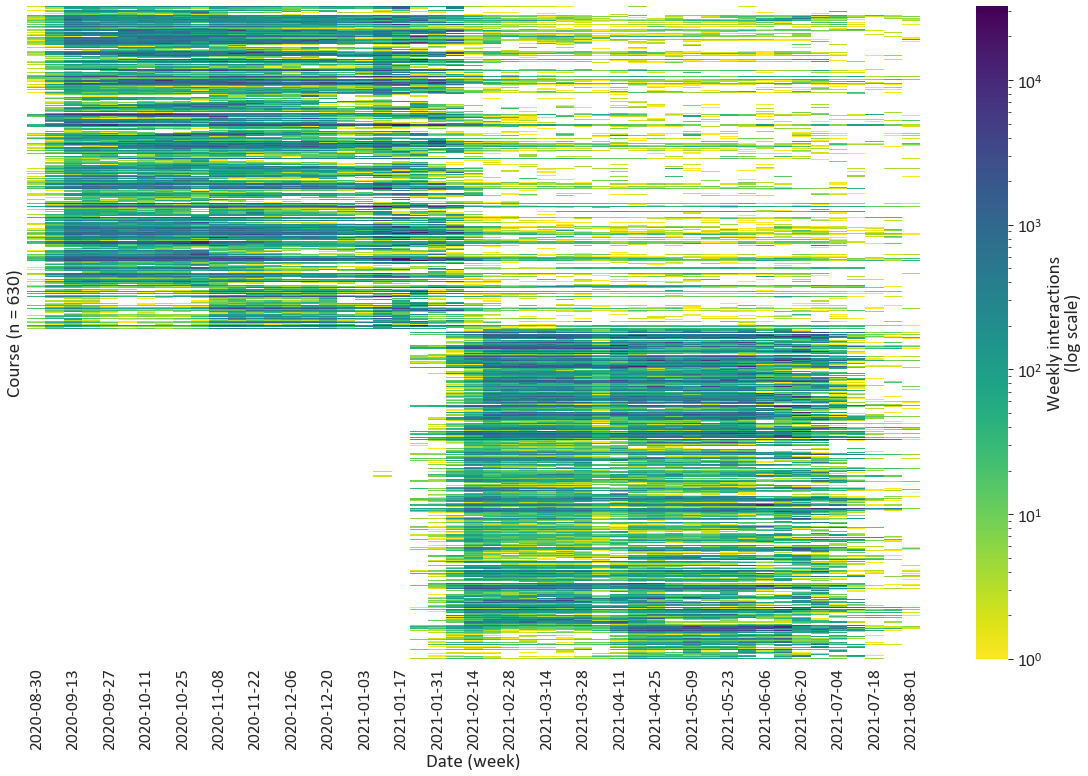

In [53]:
sns.set_theme(context='paper', style='whitegrid', font='Calibri', rc={"figure.figsize":(20, 12)}, font_scale=2)

#here, we are plotting the first
heat1 = sns.heatmap(grouped_data, robust=True, norm=LogNorm(), xticklabels = 2, yticklabels= False,
            cmap = standard_cmap, cbar_kws={'label': 'Weekly interactions\n(log scale)'})

heat1.set( ylabel=f'Course (n = {len(grouped_data.index.unique())})')

fig = heat1.get_figure()
fig.savefig('../Images/NovaIMS_exploratory_course_weekly_clicks_heatmap.png', transparent=True, dpi=300)

#delete to remove from memory
del fig, heat1

At a first glance, the interaction patterns seem to be consistent with the Semester duration. We will need to take a closer look at each Semester type separately.

**Starting with Semester 1**

In [31]:
grouped_data = deepcopy(data_grouper[data_grouper['semestre'] == 'S1'])

#change for better reading
grouped_data['Date (week)'] = grouped_data['time'].astype(str)

#creating pivot table to create heatmap
grouped_data = grouped_data.pivot_table(index =['cd_curso', 'semestre', 'courseid'], 
                       columns = 'Date (week)',
                        values = 'action', 
                       aggfunc =np.sum,
                        fill_value=np.nan)

#now, we will sort the courses according to the starting date
grouped_data['sort'] = grouped_data.index.map(sorting_hat)
grouped_data = grouped_data.reset_index().rename(columns = {'courseid': 'Course',
                                                            'cd_curso': 'Program',
                                                            'semestre': 'Semester',
                                                           })

grouped_data['Course'] = pd.to_numeric(grouped_data['Course']).astype(int)

#finally we create the pivot_table that we will use to create our heatmap
grouped_data = grouped_data.set_index(['Program', 'Semester', 'Course'], drop = True).sort_values('sort').drop('sort', axis = 1)
grouped_data.T.describe(include = 'all').T

count         mean          std  min    25%    50%  \
Program Semester Course                                                       
4281    S1       200012   32.0   162.812500   221.008019  1.0   5.75   98.0   
7512    S1       200175   49.0  1325.673469  2177.489125  3.0  23.00  123.0   
                 200178   49.0  1410.816327  4057.557474  2.0  14.00   97.0   
                 200179   48.0  1777.645833  3535.613272  2.0  22.50  145.5   
8183    S1       100003   31.0   243.612903   401.775201  1.0   9.50  168.0   
...                        ...          ...          ...  ...    ...    ...   
4969    S1       200071   21.0    81.666667    72.078661  1.0  25.00   76.0   
                 200187   11.0    10.909091     9.115421  1.0   5.50    7.0   
                 200196   22.0   122.909091   355.823379  2.0  18.50   29.5   
9435    S1       200201   28.0    91.357143    98.973328  1.0   8.00   72.5   
                 400082   36.0   155.194444   301.617622  1.0   3.75  141.5   

                             75%      max  
Program Semester Course                    
4281    S1       200012   215.75   1148.0  
7512    S1       200175  2044.00  12639.0  
                 200178  1344.00  27196.0  
                 200179  2235.75  20693.0  
8183    S1       100003   295.00   2147.0  
...                          ...      ...  
4969    S1       200071   125.00    239.0  
                 200187    15.00     27.0  
                 200196    64.00   1678.0  
9435    S1       200201   150.50    407.0  
                 400082   173.25   1781.0  

[224 rows x 8 columns]

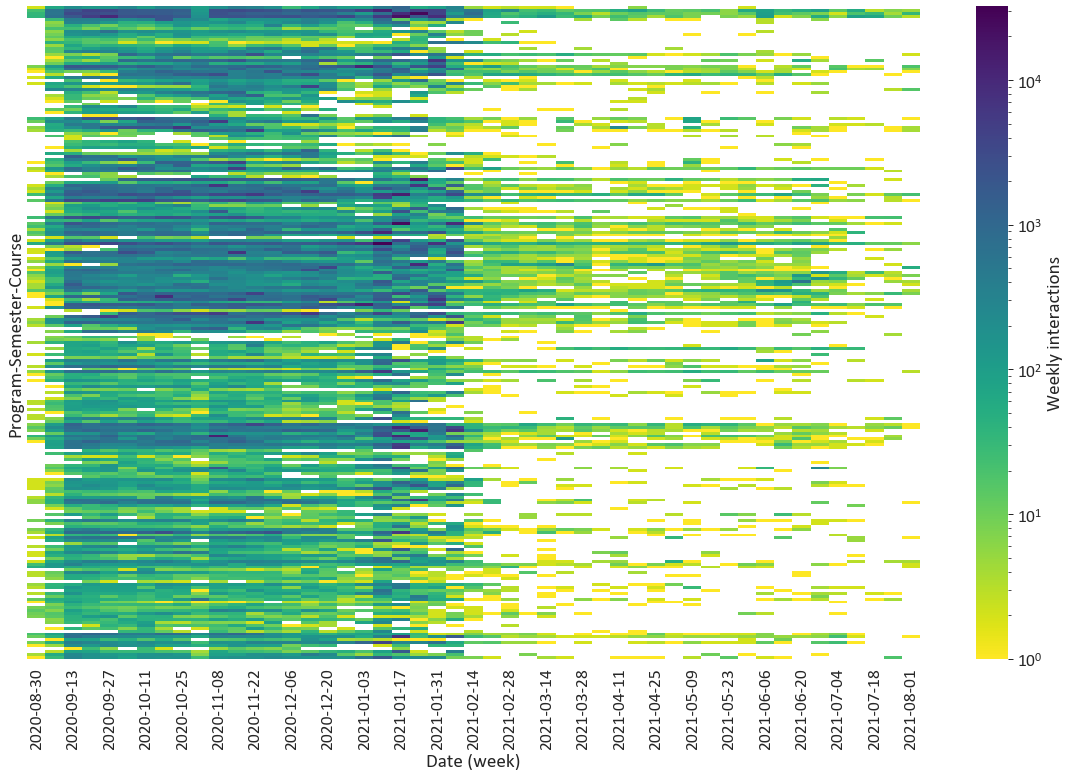

In [32]:
sns.set_theme(context='paper', style='whitegrid', font='Calibri', rc={"figure.figsize":(20, 12)}, font_scale=2)

#here, we are plotting the first
heat2 = sns.heatmap(grouped_data, robust=True, norm=LogNorm(), xticklabels = 2, yticklabels= False,
            cmap = standard_cmap, cbar_kws={'label': 'Weekly interactions'})

fig = heat2.get_figure()
fig.savefig('../Images/NovaIMS_S1_weekly_interactions.png', transparent=True, dpi=300)

#delete to remove from memory
del fig, heat2

**Trimester 1**

In [33]:
grouped_data = deepcopy(data_grouper[data_grouper['semestre'] == 'T1'])

#change for better reading
grouped_data['Date (week)'] = grouped_data['time'].astype(str)

#creating pivot table to create heatmap
grouped_data = grouped_data.pivot_table(index =['cd_curso', 'semestre', 'courseid'], 
                       columns = 'Date (week)',
                        values = 'action', 
                       aggfunc =np.sum,
                        fill_value=np.nan)

#now, we will sort the courses according to the starting date
grouped_data['sort'] = grouped_data.index.map(sorting_hat)
grouped_data = grouped_data.reset_index().rename(columns = {'courseid': 'Course',
                                                            'cd_curso': 'Program',
                                                            'semestre': 'Semester',
                                                           })

grouped_data['Course'] = pd.to_numeric(grouped_data['Course']).astype(int)

#finally we create the pivot_table that we will use to create our heatmap
grouped_data = grouped_data.set_index(['Program', 'Semester', 'Course'], drop = True).sort_values('sort').drop('sort', axis = 1)
grouped_data.T.describe(include = 'all').T

count         mean          std  min    25%   50%  \
Program Semester Course                                                      
4281    T1       200073   23.0    66.000000   117.158789  1.0   3.50   7.0   
4969    T1       200073   26.0    16.307692    26.672487  1.0   2.25   5.0   
                 200192   14.0    32.357143    43.379554  1.0   2.25  11.5   
                 200204   11.0    37.181818    27.337952  2.0  16.50  28.0   
                 400095   26.0    53.038462    82.049488  1.0   3.00   7.0   
4973    T1       400087   32.0   156.125000   248.017006  1.0   9.00  17.0   
4974    T1       400097   44.0   188.022727   328.516078  1.0   5.75  21.0   
                 400098   42.0   219.000000   384.230876  1.0   5.00  27.5   
                 400099   47.0    88.574468   178.056872  1.0   4.00  13.0   
4977    T1       200073   11.0    12.909091    16.201571  1.0   1.50   3.0   
                 200088   12.0    10.750000    21.909421  1.0   1.00   4.0   
                 200192   12.0    16.583333    33.366991  1.0   3.50   6.0   
                 200193   12.0    17.000000    17.699512  1.0   1.00  13.0   
                 200204   21.0   111.238095   133.349880  1.0   5.00  31.0   
5381    T1       200192   19.0    91.105263   154.106347  1.0   4.00  27.0   
7512    T1       200211   43.0  1492.465116  2845.541026  1.0  15.50  69.0   
9434    T1       200073   46.0   426.108696   784.524887  1.0   8.25  43.0   
                 200088   34.0   125.823529   342.552227  1.0   1.25   5.5   
                 200192   46.0   696.804348  2051.144002  1.0  13.00  33.0   
                 200193   47.0   887.255319  2328.430984  1.0  10.50  36.0   
4967    T1       200204   18.0    89.277778    96.848460  1.0   7.00  44.5   
                 200192   21.0    41.142857   108.965263  1.0   1.00   7.0   
                 200088   12.0    16.833333    33.061467  1.0   2.50   7.5   
                 200073   12.0     8.916667     8.195989  1.0   2.00   6.0   
4281    T1       200088   44.0   209.022727   633.395812  1.0   3.00   9.5   
                 200192   22.0    70.590909   171.940648  1.0   2.00  11.0   
                 200193   19.0    74.684211   122.173398  1.0   1.50  26.0   
                 200204   20.0    87.100000   108.250635  1.0   5.75  38.0   
4951    T1       200073   10.0    12.500000    11.147994  2.0   4.25   7.0   
                 200088   22.0    78.000000   141.281886  1.0   2.00  29.0   
                 200204    8.0    19.500000    15.334368  3.0   5.25  20.0   
4952    T1       200192   11.0    30.727273    66.998643  2.0   3.50   9.0   
                 200193    9.0    36.555556    37.215961  2.0   5.00  24.0   
9434    T1       200204   20.0   199.200000   255.738888  1.0   8.75  21.5   
4953    T1       200193    9.0    18.555556    34.231240  1.0   3.00   3.0   
4954    T1       200088   13.0    11.846154    14.088093  1.0   6.00   9.0   
                 200192   42.0   106.500000   220.769414  1.0   3.25  31.0   
                 200193   43.0   147.116279   328.221920  1.0   7.00  30.0   
                 200204   12.0    13.500000    15.252422  1.0   1.75  10.0   
4955    T1       200073   20.0    17.000000    21.870432  1.0   2.00   6.0   
                 200088   12.0    30.916667    81.755131  1.0   3.50   7.0   
                 200192   13.0    28.076923    24.459019  2.0  11.00  22.0   
                 200193   13.0    75.076923    78.891763  1.0  11.00  64.0   
4956    T1       200204   14.0    40.071429    48.539380  2.0   6.00  23.0   
4954    T1       200073   45.0    73.000000   112.171946  1.0   9.00  31.0   
9435    T1       200204   19.0    82.315789   102.883458  1.0   3.00  20.0   

                            75%      max  
Program Semester Course                   
4281    T1       200073  114.50    531.0  
4969    T1       200073   19.50    132.0  
                 200192   44.25    129.0  
                 200204   57.00     92.0  
                 40009

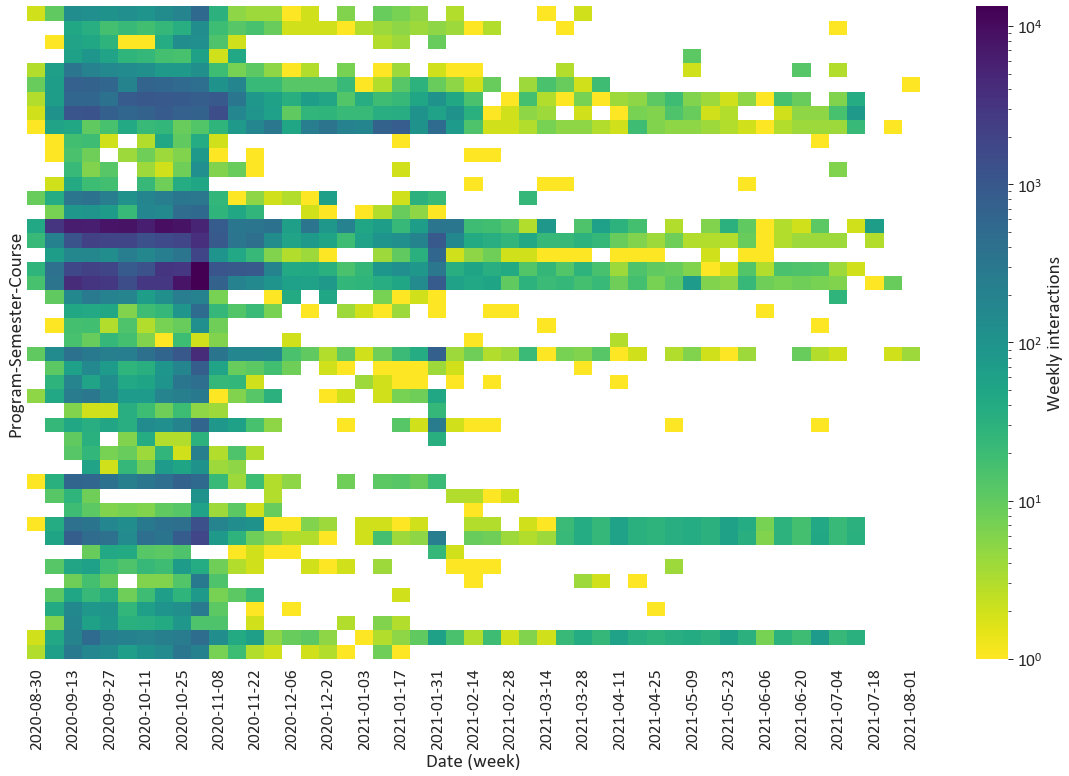

In [34]:
sns.set_theme(context='paper', style='whitegrid', font='Calibri', rc={"figure.figsize":(20, 12)}, font_scale=2)

#here, we are plotting the first
heat3 = sns.heatmap(grouped_data, robust=True, norm=LogNorm(), xticklabels = 2, yticklabels= False,
            cmap = standard_cmap, cbar_kws={'label': 'Weekly interactions'})

fig = heat3.get_figure()
fig.savefig('../Images/NovaIMS_T1_weekly_interactions.png', transparent=True, dpi=300)

#delete to remove from memory
del fig, heat3

**Trimester 2**

In [35]:
grouped_data = deepcopy(data_grouper[data_grouper['semestre'] == 'T2'])

#change for better reading
grouped_data['Date (week)'] = grouped_data['time'].astype(str)

#creating pivot table to create heatmap
grouped_data = grouped_data.pivot_table(index =['cd_curso', 'semestre', 'courseid'], 
                       columns = 'Date (week)',
                        values = 'action', 
                       aggfunc =np.sum,
                        fill_value=np.nan)

#now, we will sort the courses according to the starting date
grouped_data['sort'] = grouped_data.index.map(sorting_hat)
grouped_data = grouped_data.reset_index().rename(columns = {'courseid': 'Course',
                                                            'cd_curso': 'Program',
                                                            'semestre': 'Semester',
                                                           })

grouped_data['Course'] = pd.to_numeric(grouped_data['Course']).astype(int)

#finally we create the pivot_table that we will use to create our heatmap
grouped_data = grouped_data.set_index(['Program', 'Semester', 'Course'], drop = True).sort_values('sort').drop('sort', axis = 1)
grouped_data.T.describe(include = 'all').T

count        mean          std  min    25%   50%  \
Program Semester Course                                                     
4281    T2       200070   14.0   33.357143    43.538855  1.0   5.50  20.5   
4973    T2       200206   27.0  315.666667   406.401847  1.0  11.50  43.0   
4974    T2       400100   44.0  209.727273   656.053471  1.0   4.75  14.0   
                 400101   47.0   44.617021    65.738465  1.0   8.00  14.0   
                 400102   45.0  283.377778   786.804073  1.0   8.00  16.0   
4977    T2       200070   13.0   14.769231    18.042329  1.0   1.00   5.0   
                 200191   16.0   15.500000    28.825914  1.0   3.00   7.0   
                 200195   14.0   11.785714    15.996050  1.0   3.00   5.0   
                 200197   10.0   17.000000    23.442601  1.0   2.00  11.0   
                 400020   19.0   13.842105    25.783852  1.0   1.50   4.0   
5381    T2       200195    6.0   12.833333     8.376555  4.0   5.75  12.0   
                 200197   20.0   67.800000   114.253458  1.0   6.50  26.0   
                 400020   23.0   50.130435    78.971401  1.0   5.00  15.0   
7512    T2       200174   49.0  961.081633  3102.923285  1.0  19.00  61.0   
9434    T2       200070   47.0  243.255319   575.102088  1.0   5.00  21.0   
                 200191   26.0   43.692308   100.882414  1.0   4.00   9.5   
                 200195   47.0  483.510638   989.351783  1.0   9.50  49.0   
                 200197   47.0  838.638298  2491.572879  1.0  11.50  35.0   
4969    T2       400096   30.0   29.000000    48.105488  1.0   2.00   9.5   
                 400020   28.0   34.785714    42.518281  1.0   5.00  16.5   
                 200197   13.0   18.230769    35.050330  1.0   2.00   6.0   
                 200195   15.0   12.400000    14.627762  1.0   2.50   6.0   
4281    T2       200191   40.0   87.050000   244.385881  1.0   3.75  13.5   
                 200195   20.0   26.000000    33.712406  1.0   1.00  10.5   
                 200197   38.0  151.078947   430.379680  1.0   1.25   6.0   
                 400020   15.0    9.066667     7.923443  2.0   3.50   6.0   
4951    T2       200191   27.0   40.555556    78.026787  1.0   2.00  12.0   
4953    T2       200197    8.0   13.500000    22.475383  1.0   2.00   4.0   
4954    T2       200070   41.0   77.780488   167.296371  1.0   3.00  10.0   
                 200195   45.0   97.933333   164.463923  2.0  17.00  32.0   
9434    T2       400020   48.0  491.187500  1328.752745  1.0   9.75  48.0   
4954    T2       200197   20.0   14.100000    27.043629  1.0   1.00   4.5   
4955    T2       200195   24.0   26.750000    37.989987  1.0   3.00   9.0   
                 400020   17.0    9.882353    11.602168  1.0   2.00   3.0   
4956    T2       200195   20.0   21.550000    27.321622  1.0   1.00   7.5   
                 200197   32.0   52.406250   118.949667  1.0   2.00   7.0   
4967    T2       200070   16.0   24.562500    47.260933  1.0   3.00   6.5   
                 200191   16.0    9.437500    24.776249  1.0   1.00   3.5   
                 200195   12.0   20.416667    21.470734  1.0   2.00   8.0   
                 200197   39.0  158.179487   418.826171  1.0   3.50  11.0   
4954    T2       400020   46.0   92.760870   147.316015  1.0  13.75  33.5   
9435    T2       200197   32.0   79.218750   164.641298  1.0   2.75  16.0   

                            75%      max  
Program Semester Course                   
4281    T2       200070   45.00    168.0  
4973    T2       200206  545.00   1189.0  
4974    T2       400100   45.75   3463.0  
                 400101   42.50    252.0  
                 400102  199.00   4610.0  
4977    T2       200070   20.00     53.0  
                 200191   12.50    120.0  
                 200195   15.50     60.0  
                 200197   15.25     77.0  
                 400020    9.00     86.0  
5381    T2       200195   19.00     24.0  
                 200197   81.25    505.0  
                 400020   74.00   

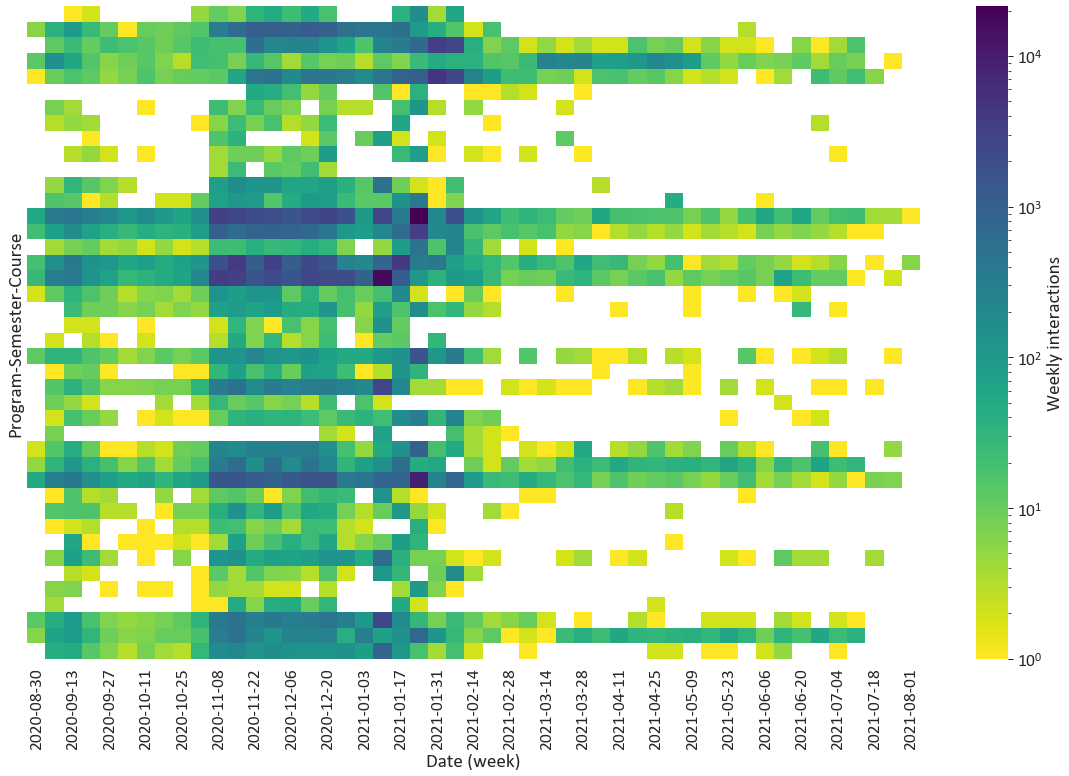

In [36]:
sns.set_theme(context='paper', style='whitegrid', font='Calibri', rc={"figure.figsize":(20, 12)}, font_scale=2)

#here, we are plotting the first
heat4 = sns.heatmap(grouped_data, robust=True, norm=LogNorm(), xticklabels = 2, yticklabels= False,
            cmap = standard_cmap, cbar_kws={'label': 'Weekly interactions'})

fig = heat4.get_figure()
fig.savefig('../Images/NovaIMS_T2_weekly_interactions.png', transparent=True, dpi=300)

#delete to remove from memory
del fig, heat4

**Semester 2**

In [37]:
grouped_data = deepcopy(data_grouper[data_grouper['semestre'] == 'S2'])

#change for better reading
grouped_data['Date (week)'] = grouped_data['time'].astype(str)

#creating pivot table to create heatmap
grouped_data = grouped_data.pivot_table(index =['cd_curso', 'semestre', 'courseid'], 
                       columns = 'Date (week)',
                        values = 'action', 
                       aggfunc =np.sum,
                        fill_value=np.nan)

#now, we will sort the courses according to the starting date
grouped_data['sort'] = grouped_data.index.map(sorting_hat)
grouped_data = grouped_data.reset_index().rename(columns = {'courseid': 'Course',
                                                            'cd_curso': 'Program',
                                                            'semestre': 'Semester',
                                                           })

grouped_data['Course'] = pd.to_numeric(grouped_data['Course']).astype(int)

#finally we create the pivot_table that we will use to create our heatmap
grouped_data = grouped_data.set_index(['Program', 'Semester', 'Course'], drop = True).sort_values('sort').drop('sort', axis = 1)
grouped_data.T.describe(include = 'all').T

count        mean         std  min    25%    50%  \
Program Semester Course                                                     
4281    S2       200013   21.0   24.904762   23.723205  1.0   7.00   17.0   
8183    S2       100051   21.0   32.095238   29.164884  1.0  12.00   23.0   
                 100063   22.0   68.818182   50.604570  1.0  33.50   62.0   
                 100064   19.0  126.000000  189.959645  2.0  16.50   20.0   
                 100075   19.0   58.421053   37.458593  1.0  34.00   60.0   
...                        ...         ...         ...  ...    ...    ...   
4967    S2       400023   20.0   60.550000   62.373641  1.0  20.50   34.0   
                 400081   24.0  563.375000  638.994646  6.0  94.75  310.5   
4969    S2       200014   22.0  110.272727  160.546739  1.0  37.25   69.0   
                 200146   20.0   34.650000   28.810223  1.0  11.25   28.5   
9435    S2       400081   25.0  345.480000  395.785834  3.0  46.00  203.0   

                            75%     max  
Program Semester Course                  
4281    S2       200013   31.00    90.0  
8183    S2       100051   52.00   111.0  
                 100063  105.50   155.0  
                 100064  183.50   679.0  
                 100075   72.50   121.0  
...                         ...     ...  
4967    S2       400023   83.75   254.0  
                 400081  716.25  2297.0  
4969    S2       200014  108.50   772.0  
                 200146   49.25   106.0  
9435    S2       400081  460.00  1307.0  

[260 rows x 8 columns]

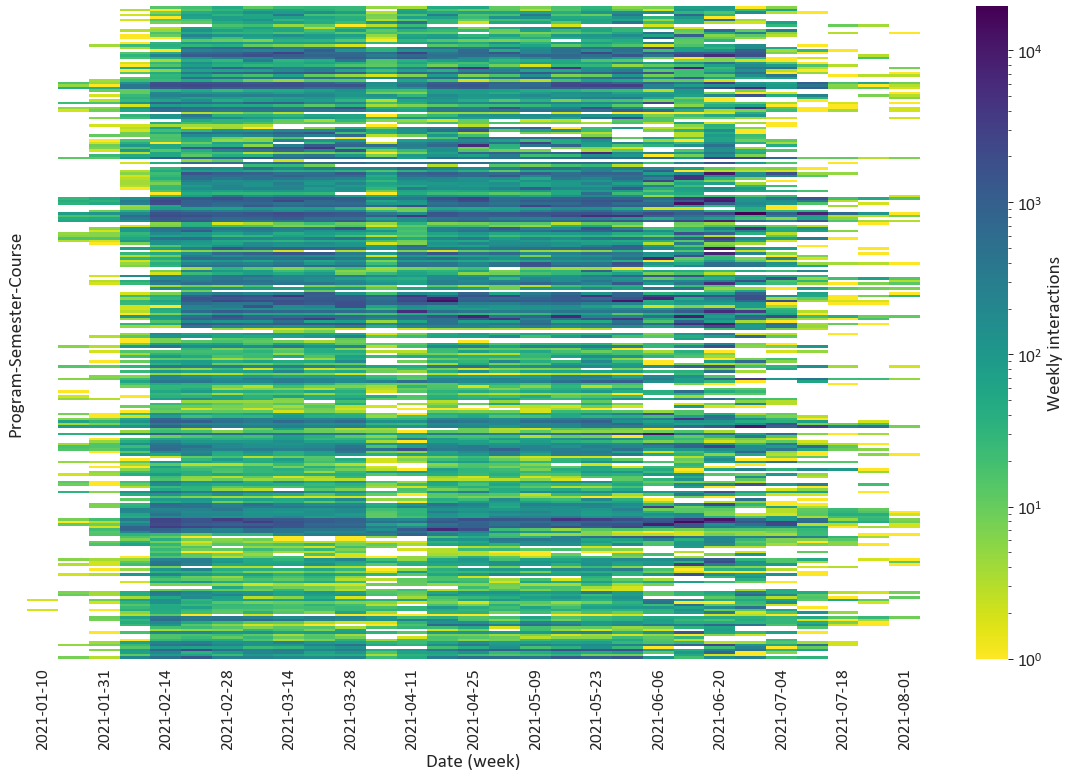

In [38]:
sns.set_theme(context='paper', style='whitegrid', font='Calibri', rc={"figure.figsize":(20, 12)}, font_scale=2)

#here, we are plotting the first
heat5 = sns.heatmap(grouped_data, robust=True, norm=LogNorm(), xticklabels = 2, yticklabels= False,
            cmap = standard_cmap, cbar_kws={'label': 'Weekly interactions'})

fig = heat5.get_figure()
fig.savefig('../Images/NovaIMS_S2_weekly_interactions.png', transparent=True, dpi=300)

#delete to remove from memory
del fig, heat5

**Trimester 3**

In [39]:
grouped_data = deepcopy(data_grouper[data_grouper['semestre'] == 'T3'])

#change for better reading
grouped_data['Date (week)'] = grouped_data['time'].astype(str)

#creating pivot table to create heatmap
grouped_data = grouped_data.pivot_table(index =['cd_curso', 'semestre', 'courseid'], 
                       columns = 'Date (week)',
                        values = 'action', 
                       aggfunc =np.sum,
                        fill_value=np.nan)

#now, we will sort the courses according to the starting date
grouped_data['sort'] = grouped_data.index.map(sorting_hat)
grouped_data = grouped_data.reset_index().rename(columns = {'courseid': 'Course',
                                                            'cd_curso': 'Program',
                                                            'semestre': 'Semester',
                                                           })

grouped_data['Course'] = pd.to_numeric(grouped_data['Course']).astype(int)

#finally we create the pivot_table that we will use to create our heatmap
grouped_data = grouped_data.set_index(['Program', 'Semester', 'Course'], drop = True).sort_values('sort').drop('sort', axis = 1)
grouped_data.T.describe(include = 'all').T

count         mean          std  min    25%    50%  \
Program Semester Course                                                       
4281    T3       200068   17.0    16.705882    17.112732  1.0   2.00   11.0   
9434    T3       200068   26.0   627.230769   875.662689  3.0  25.25  110.5   
8183    T3       200180   15.0    36.800000    36.975281  1.0   8.50   23.0   
7512    T3       200194   28.0   659.750000  2232.288472  1.0  13.75   34.5   
                 200180   27.0   535.851852   829.622560  1.0  14.50   54.0   
                 200176   28.0  1045.285714  1503.342174  1.0  33.75   53.0   
5381    T3       200210   15.0    42.066667    33.121997  1.0  14.00   43.0   
                 200068   22.0    58.227273    80.364012  1.0   3.00   11.5   
4977    T3       200210   10.0    12.000000    13.767918  1.0   3.00    6.0   
                 200068   10.0    19.300000    15.923777  4.0   8.25   17.0   
4969    T3       400040   24.0   239.250000   488.495316  2.0   5.00   40.0   
                 200210   13.0    77.538462    60.805174  1.0  23.00   70.0   
                 200068   17.0   106.294118   104.604472  1.0  16.00   92.0   
4967    T3       200068   20.0    50.100000    56.171635  1.0   3.75   38.0   
4959    T3       200210   14.0    50.714286    37.438007  1.0  20.00   50.0   
                 200068   23.0    63.000000    83.563803  1.0   1.00   12.0   
4955    T3       200210   11.0     7.545455     4.926736  1.0   4.00    6.0   
                 200068   17.0    25.882353    31.915675  1.0   2.00   19.0   
4954    T3       200210   18.0   125.388889   145.136909  1.0  11.00   85.5   
                 200068   23.0   124.782609   163.518961  3.0  11.00   22.0   
4951    T3       200198   18.0    19.111111    34.081026  1.0   4.25    9.0   
                 200068   12.0    28.083333    20.995490  1.0   5.00   31.5   
4281    T3       200210   11.0    18.090909    15.469031  1.0   4.00   20.0   
                 200198   19.0    58.842105   125.627873  1.0   3.00   18.0   
9434    T3       200198   12.0    10.583333    10.765757  2.0   5.50    7.0   
                 200210   22.0   543.409091   708.134885  1.0   6.50  101.0   

                             75%      max  
Program Semester Course                    
4281    T3       200068    26.00     54.0  
9434    T3       200068  1157.75   3262.0  
8183    T3       200180    59.00    118.0  
7512    T3       200194   352.00  11867.0  
                 200180   832.00   3455.0  
                 200176  2378.00   5018.0  
5381    T3       200210    59.00    127.0  
                 200068   100.25    267.0  
4977    T3       200210    15.75     46.0  
                 200068    20.50     55.0  
4969    T3       400040   206.75   2264.0  
                 200210   124.00    175.0  
                 200068   196.00    334.0  
4967    T3       200068    70.50    196.0  
4959    T3       200210    72.25    121.0  
                 200068   102.00    278.0  
4955    T3       200210    11.00     15.0  
                 200068    32.00    131.0  
4954    T3       200210   182.50    480.0  
                 200068   221.00    608.0  
4951    T3       200198    17.75    149.0  
                 200068    43.00     56.0  
4281    T3       200210    25.50     48.0  
                 200198    53.50    557.0  
9434    T3       200198    13.25     42.0  
                 200210   905.50   2343.0

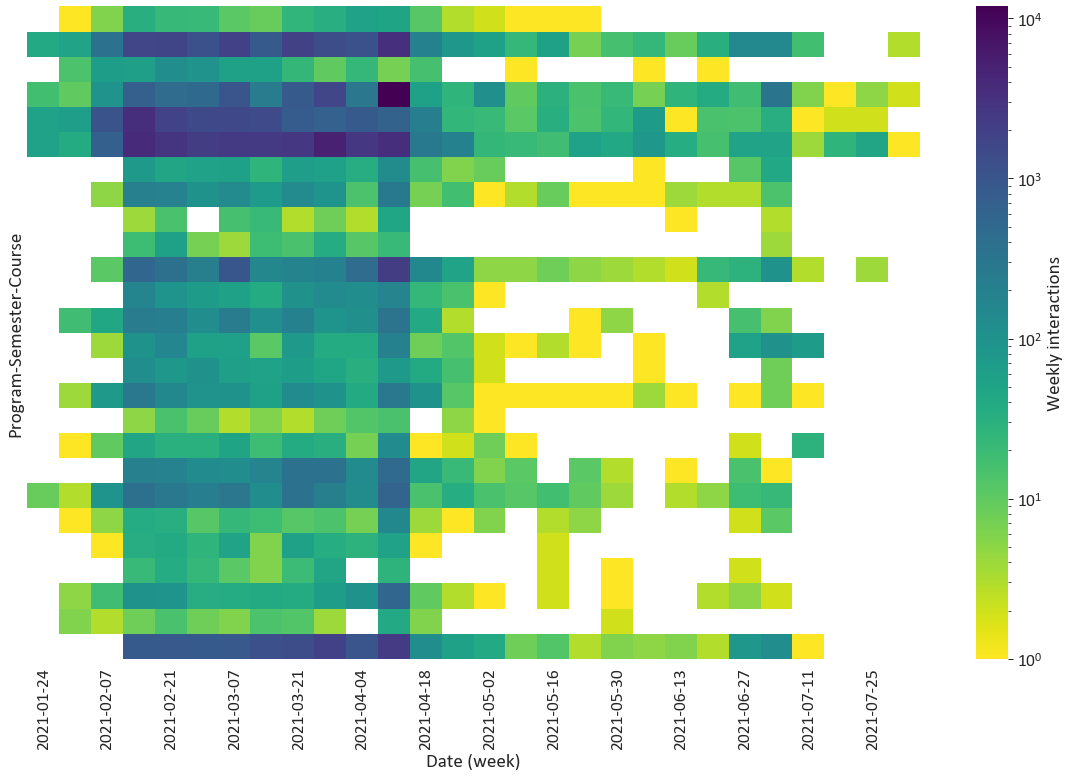

In [40]:
sns.set_theme(context='paper', style='whitegrid', font='Calibri', rc={"figure.figsize":(20, 12)}, font_scale=2)

#here, we are plotting the first
heat6 = sns.heatmap(grouped_data, robust=True, norm=LogNorm(), xticklabels = 2, yticklabels= False,
            cmap = standard_cmap, cbar_kws={'label': 'Weekly interactions'})

fig = heat6.get_figure()
fig.savefig('../Images/NovaIMS_T3_weekly_interactions.png', transparent=True, dpi=300)

#delete to remove from memory
del fig, heat6

**Trimester 4**

In [41]:
grouped_data = deepcopy(data_grouper[data_grouper['semestre'] == 'T4'])

#change for better reading
grouped_data['Date (week)'] = grouped_data['time'].astype(str)

#creating pivot table to create heatmap
grouped_data = grouped_data.pivot_table(index =['cd_curso', 'semestre', 'courseid'], 
                       columns = 'Date (week)',
                        values = 'action', 
                       aggfunc =np.sum,
                        fill_value=np.nan)

#now, we will sort the courses according to the starting date
grouped_data['sort'] = grouped_data.index.map(sorting_hat)
grouped_data = grouped_data.reset_index().rename(columns = {'courseid': 'Course',
                                                            'cd_curso': 'Program',
                                                            'semestre': 'Semester',
                                                           })

grouped_data['Course'] = pd.to_numeric(grouped_data['Course']).astype(int)

#finally we create the pivot_table that we will use to create our heatmap
grouped_data = grouped_data.set_index(['Program', 'Semester', 'Course'], drop = True).sort_values('sort').drop('sort', axis = 1)
grouped_data.T.describe(include = 'all').T

count         mean          std  min    25%    50%  \
Program Semester Course                                                       
4281    T4       200194   19.0   107.000000   176.613829  1.0   6.00   38.0   
9434    T4       200217   24.0   171.333333   266.046198  1.0   7.75   34.5   
                 200200   23.0    84.695652    95.018388  2.0   9.00   50.0   
                 200194   27.0  1044.851852  2511.726769  2.0  30.50   66.0   
7512    T4       200207   26.0  1146.153846  1645.567591  1.0   5.00   65.0   
                 200181   28.0   795.642857  1319.231432  2.0  21.00  104.5   
                 200014   28.0   726.250000  1647.935513  1.0  16.00   90.0   
5381    T4       200217   19.0    66.526316    82.049693  1.0   3.00   17.0   
                 200200   11.0    13.363636     7.553446  2.0   8.00   14.0   
                 200194    8.0    28.375000    50.016961  1.0   1.00    3.5   
4977    T4       200200   17.0    10.529412    13.910956  1.0   2.00    3.0   
                 200194   16.0    59.687500   115.600876  1.0   1.00    9.5   
4969    T4       400094   26.0   141.807692   221.978921  2.0  21.75   77.5   
                 200217   15.0    28.866667    28.098975  1.0   4.00   22.0   
                 200194   23.0   131.347826   258.829816  1.0  10.50   48.0   
4967    T4       200200   24.0    78.875000    91.526814  3.0   8.75   17.5   
                 200194   21.0   188.428571   387.442328  1.0   4.00   15.0   
4959    T4       200217   17.0    38.058824    37.939871  1.0  12.00   25.0   
                 200200   16.0     8.562500     6.334759  1.0   3.75    7.0   
4956    T4       200200   14.0     9.214286     5.898873  1.0   5.25    9.5   
                 200194   15.0    57.666667   111.964067  1.0   7.50   16.0   
4955    T4       200217   14.0    26.357143    29.852476  1.0   2.50   17.0   
                 200200   11.0     4.000000     3.065942  1.0   2.00    3.0   
4954    T4       200217   21.0    78.809524   127.431008  1.0   6.00   26.0   
                 200200   10.0    11.100000    10.785278  2.0   3.00    8.0   
                 200194   23.0   223.130435   483.125742  2.0   7.50   21.0   
4953    T4       200194    9.0    22.333333    29.597297  1.0   2.00    3.0   
4951    T4       200217    9.0    20.777778    17.809954  3.0   9.00   17.0   
                 200205   16.0    25.562500    43.294293  1.0   3.00   11.5   
4281    T4       200205   21.0    54.333333   106.672552  1.0   3.00   20.0   
9435    T4       200194   11.0    19.363636    27.038020  1.0   1.50    7.0   
                 200200   25.0    43.240000    52.283108  3.0   6.00   18.0   

                             75%      max  
Program Semester Course                    
4281    T4       200194    94.50    676.0  
9434    T4       200217   207.50   1088.0  
                 200200   126.50    356.0  
                 200194   487.50  11703.0  
7512    T4       200207  2383.50   5528.0  
                 200181  1196.75   5190.0  
                 200014   850.75   8400.0  
5381    T4       200217   119.50    246.0  
                 200200    18.50     24.0  
                 200194    32.25    146.0  
4977    T4       200200    17.00     56.0  
                 200194    38.75    424.0  
4969    T4       400094   191.75   1126.0  
                 200217    49.50     86.0  
                 200194    88.00   1131.0  
4967    T4       200200   160.25    298.0  
                 200194   105.00   1612.0  
4959    T4       200217    64.00    108.0  
                 200200    12.00     22.0  
4956    T4       200200    12.50     19.0  
                 200194    51.50    442.0  
4955    T4       200217    42.25    102.0  
                 200200     5.00     10.0  
4954    T4       200217   128.00    565.0  
                 200200    13.00     36.0  
                 200194   116.50   2106.0  
4953    T4       200194    27.00     76.0  
4951    T4       200217    26.00     62.0  
                 2

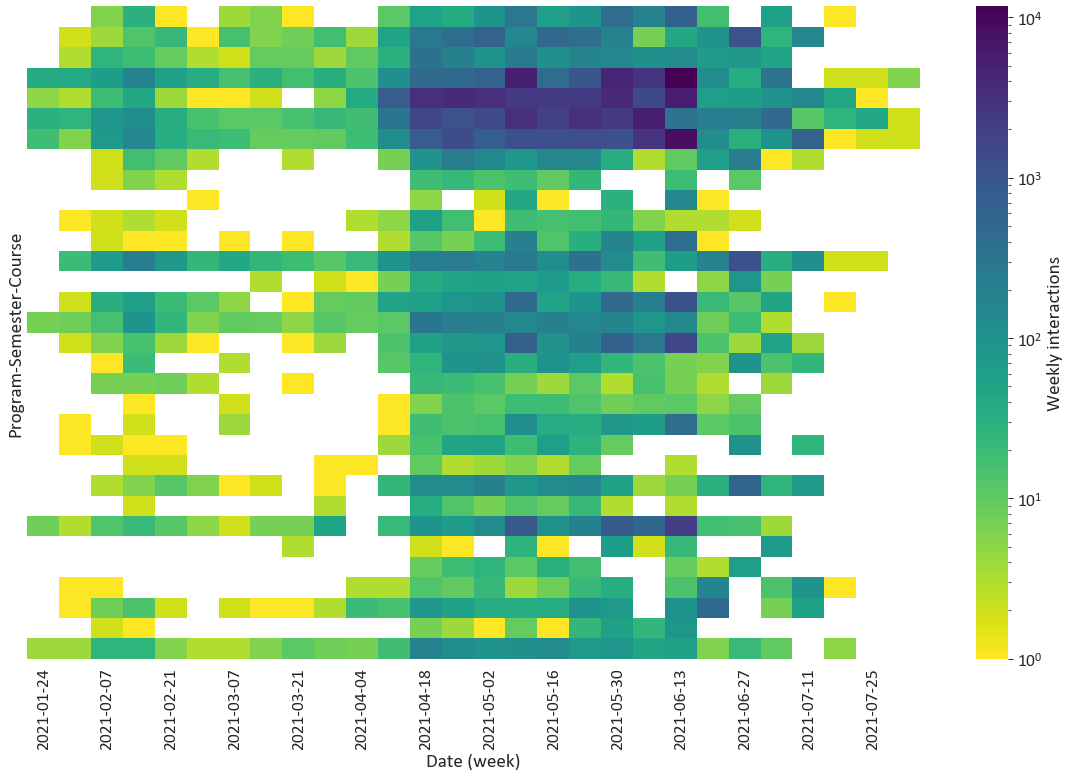

In [42]:
sns.set_theme(context='paper', style='whitegrid', font='Calibri', rc={"figure.figsize":(20, 12)}, font_scale=2)

#here, we are plotting the first
heat7 = sns.heatmap(grouped_data, robust=True, norm=LogNorm(), xticklabels = 2, yticklabels= False,
            cmap = standard_cmap, cbar_kws={'label': 'Weekly interactions'})

fig = heat7.get_figure()
fig.savefig('../Images/NovaIMS_T4_weekly_interactions.png', transparent=True, dpi=300)

#delete to remove from memory
del fig, heat7, grouped_data

**We can, additionally**, make some additional observations that may come in handy in the future:

a. How many students are attending each course,

b. How many courses is each student attending,

This knowledge will allow us make additional filtering decisions to enhance our sample.

In [43]:
#we can compute the number of students attending each course, and the number of courses each student is attending
class_list = student_courses.groupby(['cd_curso', 'semestre', 'courseid'])['userid'].count().to_frame().rename(columns = {'userid' : 'Users per course'})
enrollment_size = student_courses.groupby('userid')['courseid'].count().to_frame().rename(columns = {'courseid' : 'Courses per User'})

**A. How many students are attending each course?**

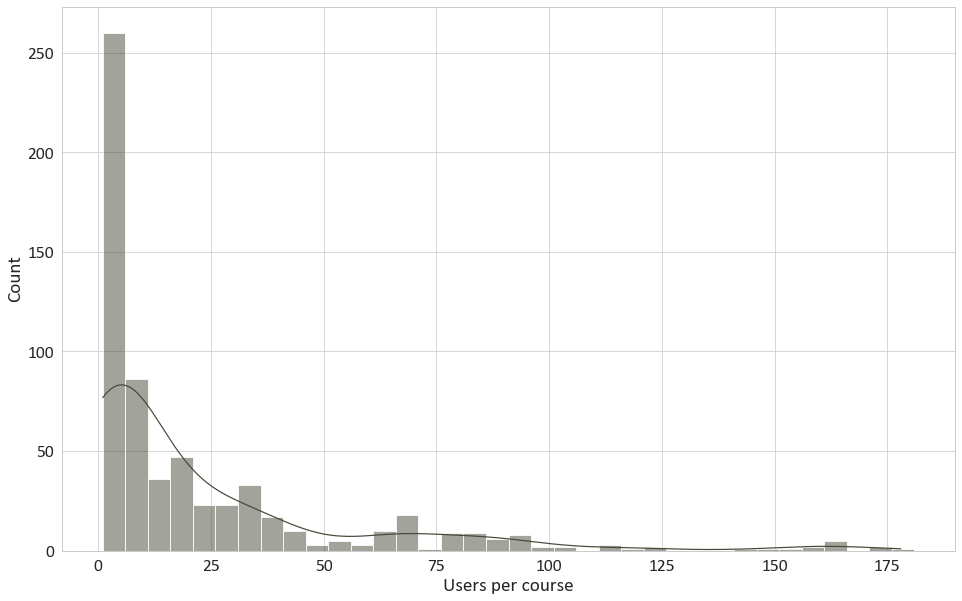

In [44]:
#settub
sns.set_theme(context='paper', style='whitegrid', font='Calibri', rc={"figure.figsize":(16, 10)}, font_scale=2)

#a number of students per course
#student_courses.rename(columns = {'userid' : 'Students per course'}, inplace = True)

#then we plot an histogram with all courses, we are not interested in keeping courses with a number of students inferior to 10
hist1 = sns.histplot(data=class_list, x='Users per course', kde=True, color= student_color, binwidth = 5,)

fig = hist1.get_figure()
fig.savefig('../Images/Nova_IMS_hist1_students_per_course_bin_5.png', transparent=True, dpi=300)

#delete to remove from memory
del fig, hist1

**There is a very significant number of courses with between 1 and 10 students**

**B. In how many courses is each student enrolled?**

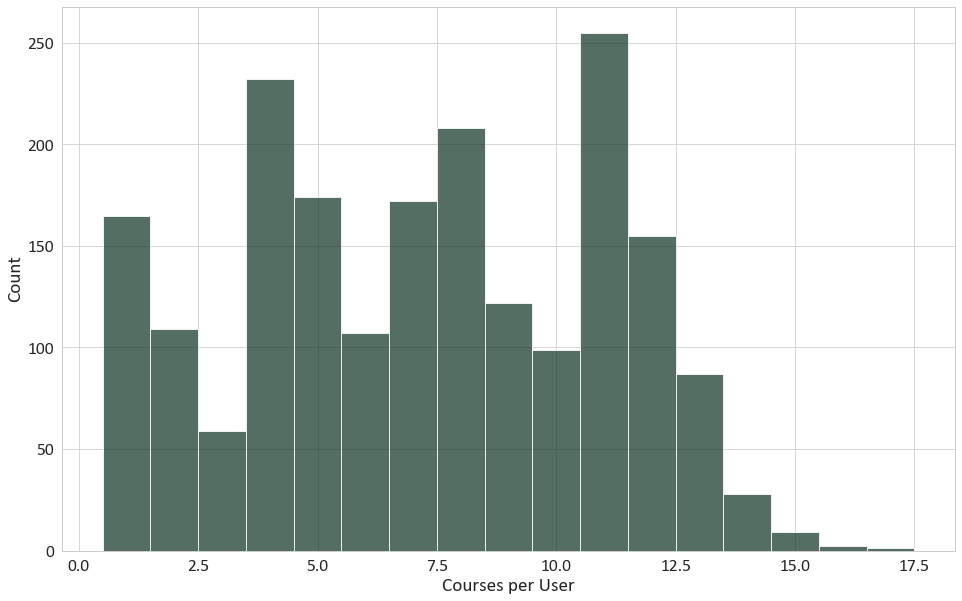

In [45]:
#then we plot an histogram with all courses, we are not interested in keeping courses with a number of students inferior to 10
hist2 = sns.histplot(data= enrollment_size, 
        x='Courses per User', color= course_color, discrete = True, fill = True)

fig = hist2.get_figure()
fig.savefig('../Images/Nova_IMS_hist2_courses_per_student course_bin_1.png', transparent=True, dpi=300)

#delete to remove from memory
del fig, hist2

Depending on the course in question, it is possible for it to have 1 registered user vs almost 175.
Additionally, we can also see that there is a significant number of students attending a single course (over 150).

To some extent, most courses have some degree of interaction with Moodle, no matter how small.

We can see that interactions with a Course will usually start as the starting date approaches - regardless of the semester in question. Usually, accesses past the end of course date still continue occuring - liklely to access some educational content.

Additionally, course interactions are consistent with the intentional splits many courses seem, at least on a preliminary level, be consistent with the split between semesters and trimesters.

### So, what's next?

Well, we are going back to the original script. We arte going to complete our course list. We'll need to add The start-date, end date, course duration, course size and, finally, 

In [46]:
#start date
class_list['Start Date'] = class_list.index.to_series().map(sorting_hat)

#end date
class_list['End Date'] = class_list.index.to_series().map(ending_hat)
class_list['End Date'] = class_list['End Date'].where( class_list['End Date'] == (( class_list['End Date'] + Week(weekday=4) ) - Week()), class_list['End Date'] + Week(weekday=4))

#additionally, we will look at our estimated course duration
class_list['Course duration days'] = class_list['End Date'] - class_list['Start Date']
class_list

Users per course Start Date   End Date  \
cd_curso semestre courseid                                           
4281     S1       200012.0                15 2020-09-07 2021-01-22   
                  200032.0                10 2020-09-07 2021-01-22   
                  200071.0                 3 2020-09-07 2021-01-22   
                  200101.0                65 2020-09-07 2021-01-22   
                  200159.0                65 2020-09-07 2021-01-22   
...                                      ...        ...        ...   
9435     S2       400081.0                17 2021-02-08 2021-06-25   
         T1       200204.0                11 2020-09-07 2020-11-06   
         T2       200197.0                 6 2020-11-02 2021-01-22   
         T4       200194.0                 1 2021-04-12 2021-06-11   
                  200200.0                17 2021-04-12 2021-06-11   

                           Course duration days  
cd_curso semestre courseid                       
4281     S1       200012.0             137 days  
                  200032.0             137 days  
                  200071.0             137 days  
                  200101.0             137 days  
                  200159.0             137 days  
...                                         ...  
9435     S2       400081.0             137 days  
         T1       200204.0              60 days  
         T2       200197.0              81 days  
         T4       200194.0              60 days  
                  200200.0              60 days  

[630 rows x 4 columns]

**Now, we will fininsh our work by removing all logs outside the following conditions.**

We will build 2 cutoff points:

1. One week before the start date of the course, 
2. After the perceived end of course.

In [47]:
#a new look into class list
class_list['cuttoff_point'] = pd.to_datetime((class_list['Start Date'] - pd.to_timedelta(1, unit = 'W')).dt.date)

#convert to date
class_list['Start Date'] = pd.to_datetime(class_list['Start Date'].dt.date)
class_list['End Date'] = pd.to_datetime(class_list['End Date'].dt.date)
class_list['Course duration days'] = class_list['End Date'] - class_list['Start Date']
class_list['Course duration days'] = (class_list['Course duration days'].dt.total_seconds() // 3600 // 24) + 1

#we will create a new dict with the start date
cuttoff_point = class_list.to_dict()['cuttoff_point'] 

#we'll create a new column that will signal whether we are whithin our course boundaries or not
student_logs.set_index(['cd_curso', 'semestre', 'courseid'], drop = True, inplace = True)

student_logs['start_bound'] = student_logs.index.map(cuttoff_point)
student_logs['end_bound'] = student_logs.index.map(ending_hat)

#convert to date
student_logs['start_bound'] = pd.to_datetime(student_logs['start_bound'].dt.date)
student_logs['end_bound'] = pd.to_datetime(student_logs['end_bound'].dt.date)

**Now, we only keep rows that are inside between the dates inside the start and end bounds.**

In [48]:
student_logs = student_logs[student_logs['time'].between(student_logs['start_bound'], student_logs['end_bound'], inclusive = True)].reset_index()
student_logs

,cd_curso,semestre,courseid,component,action,target,objecttable,userid,time,CourseFullname,nm_curso_pt,ds_discip_pt,start_bound,end_bound
0,4964,S1,400033.0,core,viewed,course,NaN,4867.0,2020-08-31 14:35:00,202021 - InteligÃªncia EconÃ³mica e Competitiv...,Pós-Graduação em Gestão de Informações e Segur...,Inteligência Económica e Competitiva,2020-08-31,2021-01-22
1,4964,S1,400033.0,mod_forum,viewed,course_module,forum,4867.0,2020-08-31 14:35:00,202021 - InteligÃªncia EconÃ³mica e Competitiv...,Pós-Graduação em Gestão de Informações e Segur...,Inteligência Económica e Competitiva,2020-08-31,2021-01-22
2,4964,S1,400033.0,mod_folder,viewed,course_module,folder,4867.0,2020-09-07 09:23:00,202021 - InteligÃªncia EconÃ³mica e Competitiv...,Pós-Graduação em Gestão de Informações e Segur...,Inteligência Económica e Competitiva,2020-08-31,2021-01-22
3,4964,S1,400033.0,mod_folder,viewed,course_module,folder,4867.0,2020-09-07 09:23:00,202021 - InteligÃªncia EconÃ³mica e Competitiv...,Pós-Graduação em Gestão de Informações e Segur...,Inteligência Económica e Competitiva,2020-08-31,2021-01-22
4,4964,S1,400033.0,mod_folder,viewed,course_module,folder,4867.0,2020-09-07 09:23:00,202021 - InteligÃªncia EconÃ³mica e Competitiv...,Pós-Graduação em Gestão de Informações e Segur...,Inteligência Económica e Competitiva,2020-08-31,2021-01-22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3656845,4974,S2,400106.0,core,viewed,course,NaN,6512.0,2021-06-24 19:45:00,Big Data for Finance,Pós-Graduação em Data Science for Finance,Big Data for Finance,2021-02-01,2021-06-25
3656846,9434,S2,200167.0,core,viewed,course,NaN,4118.0,2021-06-13 09:36:00,Big Data Analytics (night),Mestrado em Gestão de Informação,Big Data Analytics,2021-02-01,2021-06-25
3656847,4955,S2,200013.0,core,viewed,course,NaN,6029.0,2021-06-16 18:31:00,202021 - Business Intelligence II - Turma TPDA...,Pós-Graduação em Gestão do Conhecimento e Busi...,Business Intelligence II,2021-02-01,2021-06-25
3656848,4955,S2,200013.0,core,viewed,course,NaN,6029.0,2021-06-17 18:14:00,202021 - Business Intelligence II - Turma TPDA...,Pós-Graduação em Gestão do Conhecimento e Busi...,Business Intelligence II,2021-02-01,2021-06-25


**After finishing, we will now take a new look at the weekly interactions.**

We are expecting a cleaner view at the weekly interactions performed by students in the context of their courses.

In [49]:
#Then, when it comes to logs, we aggregate by week
grouped_data = student_logs.groupby([pd.Grouper(key='time', freq='W'), 'cd_curso', 'semestre', 'courseid']).agg({
                                                                             'action': 'count',
                                                                             }).reset_index().sort_values('time')

#change for better reading
grouped_data['Date (week)'] = grouped_data['time'].astype(str)

#creating pivot table to create heatmap
grouped_data = grouped_data.pivot_table(index =['cd_curso', 'semestre', 'courseid'], 
                       columns = 'Date (week)',
                        values = 'action', 
                       aggfunc =np.sum,
                        fill_value=np.nan)

#now, we will sort the courses according to the starting date
grouped_data['sort'] = grouped_data.index.map(sorting_hat)
grouped_data = grouped_data.reset_index().rename(columns = {'courseid': 'Course',
                                                            'cd_curso': 'Program',
                                                            'semestre': 'Semester',
                                                           })

grouped_data['Course'] = pd.to_numeric(grouped_data['Course']).astype(int)

#finally we create the pivot_table that we will use to create our heatmap
grouped_data = grouped_data.set_index(['Program', 'Semester', 'Course'], drop = True).sort_values('sort').drop('sort', axis = 1)
grouped_data.T.describe(include = 'all').T

count        mean         std   min    25%    50%  \
Program Semester Course                                                      
4281    S1       200012   21.0  227.047619  242.837904  28.0  95.00  186.0   
4969    S1       200196   21.0  110.857143  359.979900   2.0  18.00   29.0   
                 200187   11.0   10.909091    9.115421   1.0   5.50    7.0   
                 200071   18.0   91.055556   73.527484   2.0  26.75   80.5   
4967    T1       200204   10.0  147.800000   94.074202   7.0  82.75  171.5   
...                        ...         ...         ...   ...    ...    ...   
4951    T4       200217    7.0   17.428571    8.599557   9.0  10.00   17.0   
                 200205    9.0   13.555556   11.091789   3.0   4.00   10.0   
4281    T4       200205    9.0   51.777778   28.300962  15.0  34.00   37.0   
4955    T4       200200    6.0    5.833333    3.060501   3.0   3.25    5.0   
9435    T4       200200   10.0   91.000000   52.864607  18.0  53.50   90.0   

                            75%     max  
Program Semester Course                  
4281    S1       200012  264.00  1148.0  
4969    S1       200196   46.00  1678.0  
                 200187   15.00    27.0  
                 200071  145.25   239.0  
4967    T1       200204  205.25   279.0  
...                         ...     ...  
4951    T4       200217   22.50    31.0  
                 200205   22.00    36.0  
4281    T4       200205   74.00   101.0  
4955    T4       200200    8.25    10.0  
9435    T4       200200  121.00   192.0  

[630 rows x 8 columns]

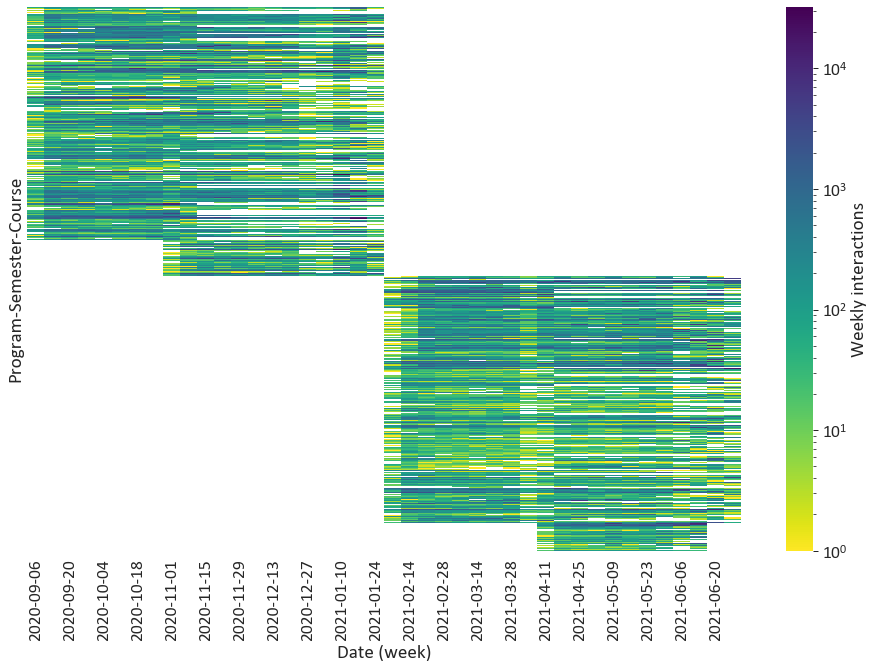

In [50]:
#here, we are plotting the nex
heat8 = sns.heatmap(grouped_data, robust=True, norm=LogNorm(), xticklabels = 2, yticklabels= False,
            cmap = standard_cmap, cbar_kws={'label': 'Weekly interactions'})

fig = heat8.get_figure()
fig.savefig('../Images/Nova_IMS_cleaned_weekly_clicks.png', transparent=True, dpi=300)

#delete to remove from memory
del fig, heat8

We finish the notebook by saving the cleaned logs and the list of the courses with which we will be going forward in our analysis. 

A very important factor to take into account is the fact that, as our targets, we will only have access to the student-pairt courses that we were able to identify in our targets table - which are the same as the ones present iin our support_table.

It is, therefore, wise to perform a last filtering step before going forward.

In [51]:
#save tables 
class_list.to_csv('../Data/Modeling Stage/NovaIMS_class_duration.csv') 

student_logs.drop(['start_bound', 'end_bound'], axis = 1).to_csv('../Data/Modeling Stage/NovaIMS_cleaned_logs.csv')

#### Done

From here on out, we will continue with feature engineering and extraction for modeling purposes in Notebooks 3.